In [10]:
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn.functional import softmax
from torchvision import transforms, models
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

## Dataset

In [2]:
# Dataset class
class DigitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.FloatTensor(images).reshape(-1, 1, 40, 168)
        self.labels = torch.LongTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Model

In [3]:
# ResNet18 based model
class ResNetModel(nn.Module):
    def __init__(self, num_classes=37):
        super(ResNetModel, self).__init__()
        # Load pretrained ResNet18
        self.resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify first conv layer to accept single channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final FC layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# PyTorch Lightning wrapper
class LitResNetModel(pl.LightningModule):
    def __init__(self, num_classes=37):
        super().__init__()
        self.save_hyperparameters()
        self.model = ResNetModel(num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        
        # Lists to store metrics per epoch
        self.train_losses_epoch = []
        self.val_losses_epoch = []
        self.train_acc_epoch = []
        self.val_acc_epoch = []
        self.test_predictions = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
    
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        
        # Store predictions and labels for confusion matrix
        self.test_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        self.test_labels.extend(labels.cpu().numpy())
        
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=5e-4,  # Fixed learning rate
            weight_decay=5e-2  # Fixed weight decay
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }

    def on_train_epoch_end(self):
        # Get the metrics logged for this epoch
        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_losses_epoch.append(train_loss.item())
        self.train_acc_epoch.append(train_acc.item())

    def on_validation_epoch_end(self):
        if "val_loss" in self.trainer.callback_metrics:
            val_loss = self.trainer.callback_metrics["val_loss"]
            val_acc = self.trainer.callback_metrics["val_acc"]
            self.val_losses_epoch.append(val_loss.item())
            self.val_acc_epoch.append(val_acc.item())

    def on_train_end(self):
        # Plot loss curves
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses_epoch, label='Training Loss')
        plt.plot(self.val_losses_epoch, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves')
        plt.legend()
        plt.savefig('loss_curves.png')
        plt.close()
        
        # Plot accuracy curves
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_acc_epoch, label='Training Accuracy')
        plt.plot(self.val_acc_epoch, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy Curves')
        plt.legend()
        plt.savefig('accuracy_curves.png')
        plt.close()

    def on_test_end(self):
        cm = confusion_matrix(self.test_labels, self.test_predictions)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        plt.close()

## Main

In [4]:
# Set medium precision
torch.set_float32_matmul_precision('medium')

test_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/test_data.npy', allow_pickle=True)
lab_test_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/test_lab.npy', allow_pickle=True)

test_dataset = DigitDataset(test_data, lab_test_data)
print(f"Testing data shapes - Images: {test_data.shape}, Labels: {lab_test_data.shape}")

# Data loaders
batch_size = 256  # Fixed batch size
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Model training
model = LitResNetModel()
logger = TensorBoardLogger("logs", name="resnet_model")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/data/gaurav.bhole/MLNS/final_train_orig",
    filename="resnet_model-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    precision='16-mixed',
    max_epochs=100,
    # devices='auto',
    devices=1,
    logger=logger,
    # strategy='ddp' if torch.cuda.device_count() > 1 else None,
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=5)],
    log_every_n_steps=10,
)

# load the best model
model = LitResNetModel.load_from_checkpoint('/data/gaurav.bhole/MLNS/final_train_orig/resnet_model-epoch=77-val_loss=0.2336.ckpt')

# Test the model
print("\nEvaluating the model on the test set...")
trainer = pl.Trainer(devices=1, num_nodes=1)
trainer.test(model, test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing data shapes - Images: (6000, 40, 168), Labels: (6000,)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Evaluating the model on the test set...
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 26.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.906166672706604     │
│         test_loss         │    0.4107973277568817     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4107973277568817, 'test_acc': 0.906166672706604}]

## Visualization

In [5]:
def visualize_predictions(model, test_loader, num_samples=10, samples_per_row=5):
    """
    Visualize model predictions similar to the example image with:
    - Predicted label
    - True label
    - Confidence score
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Store samples and their predictions
    samples = []
    all_images = []
    all_preds = []
    all_labels = []
    all_confidences = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)
            
            # Store batch results
            all_images.extend(images.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_confidences.extend(confidences.cpu().numpy())
            
            if len(all_images) >= num_samples:
                break
    
    # Create figure
    rows = (num_samples + samples_per_row - 1) // samples_per_row
    fig = plt.figure(figsize=(20, 4 * rows))
    
    # Plot the first num_samples images
    for idx in range(min(num_samples, len(all_images))):
        ax = plt.subplot(rows, samples_per_row, idx + 1)
        
        # Display the image
        plt.imshow(all_images[idx][0], cmap='gray')
        plt.axis('off')
        
        # Color coding: green for correct predictions, red for incorrect
        color = 'green' if all_preds[idx] == all_labels[idx] else 'red'
        
        # Add text above image
        title = f'Pred: {all_preds[idx]} (True: {all_labels[idx]})\nConf: {all_confidences[idx]:.2f}'
        plt.title(title, color=color, pad=10)
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png', bbox_inches='tight', dpi=150)
    plt.close()

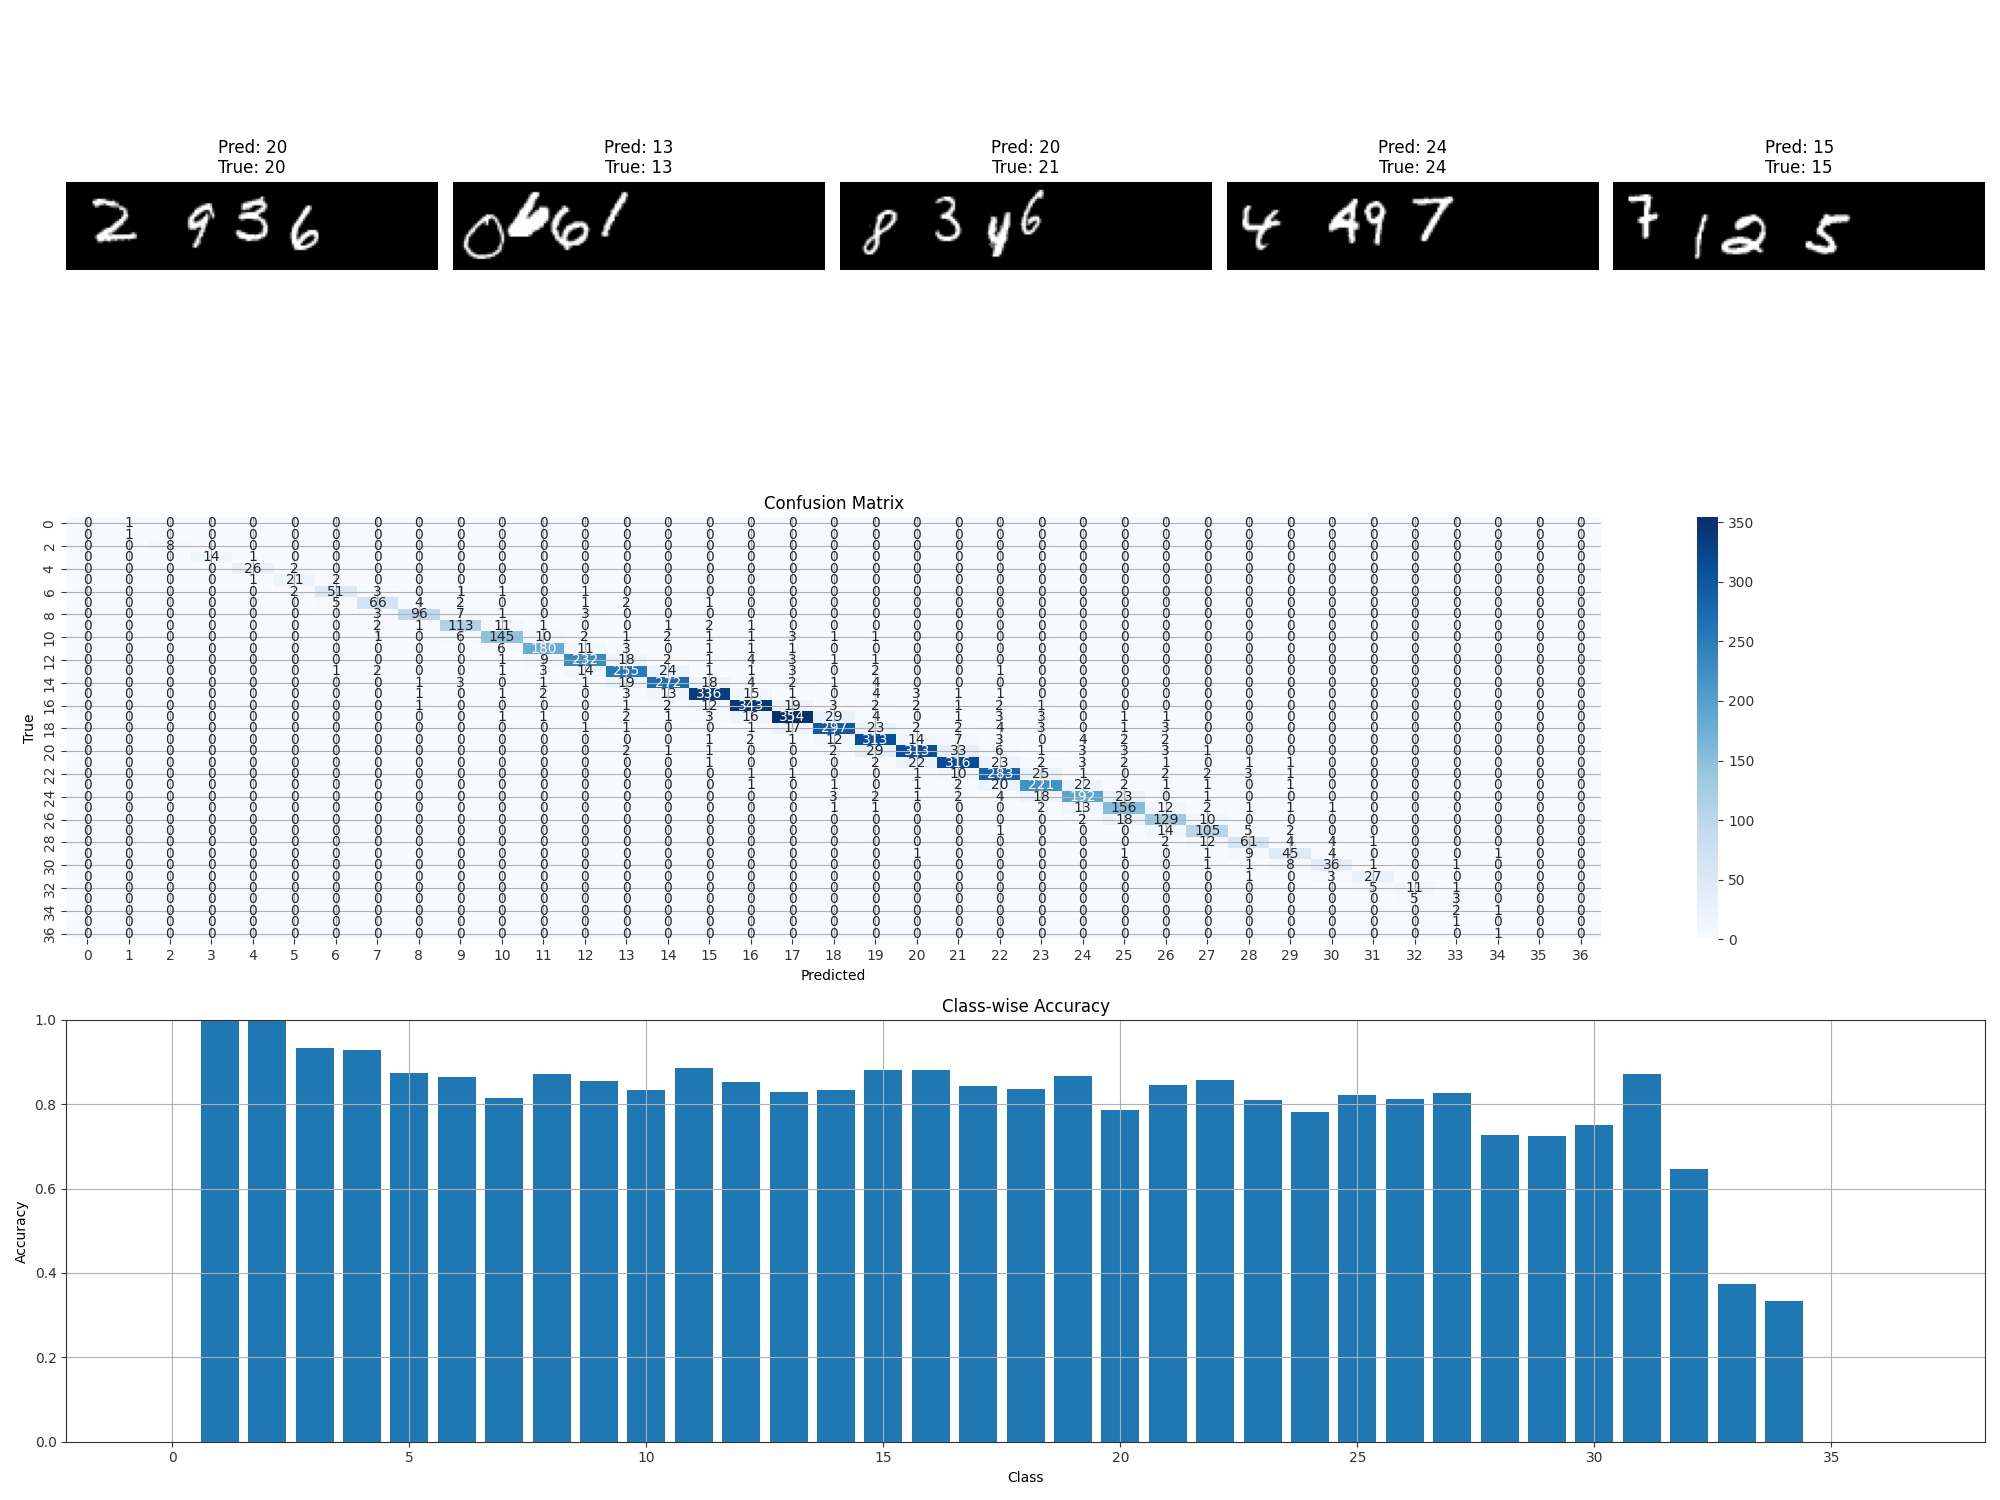

In [9]:
visualize_predictions(model, test_loader)
Image(filename='prediction_visualization.png')

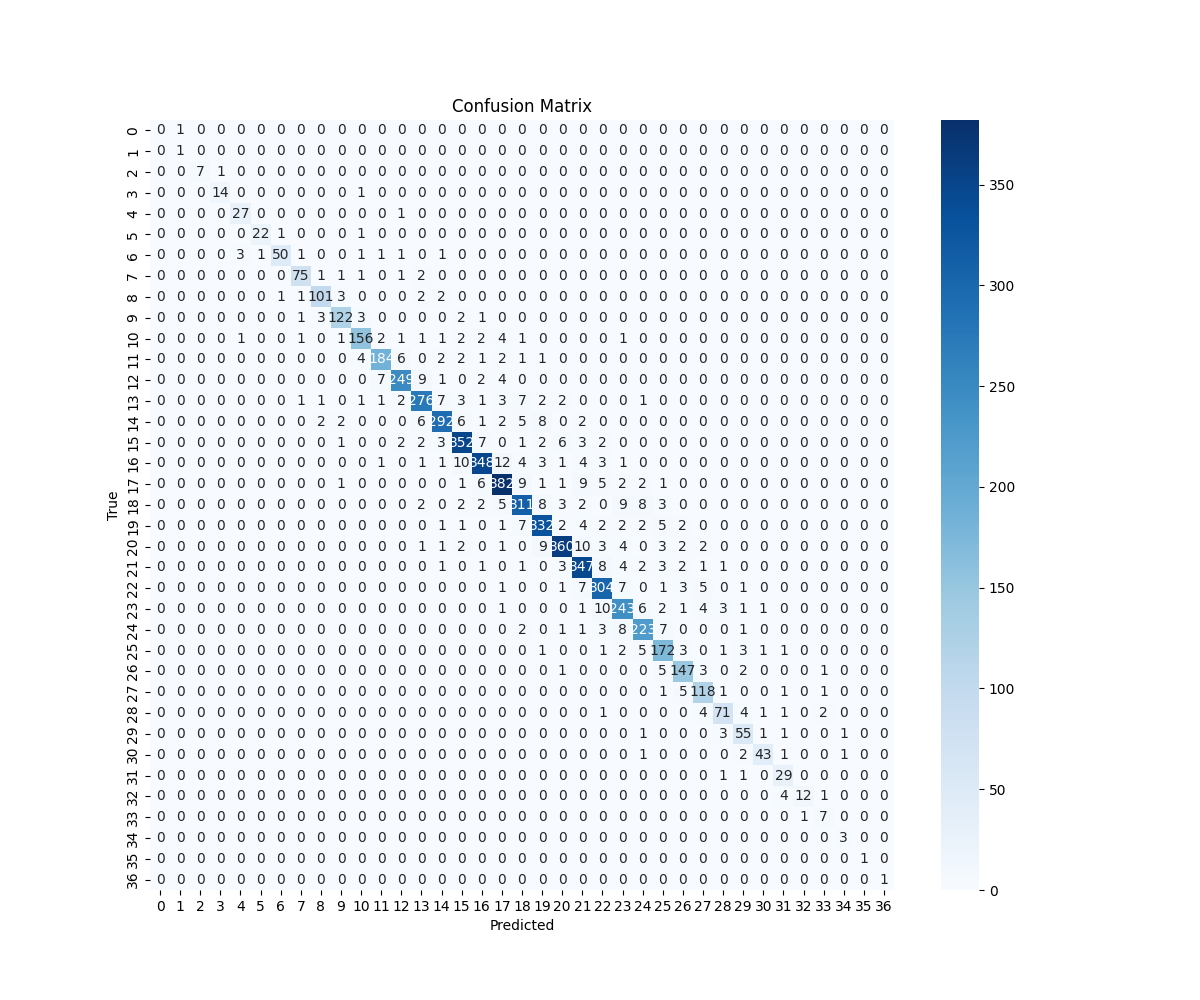

In [11]:
Image(filename='confusion_matrix_best.png')

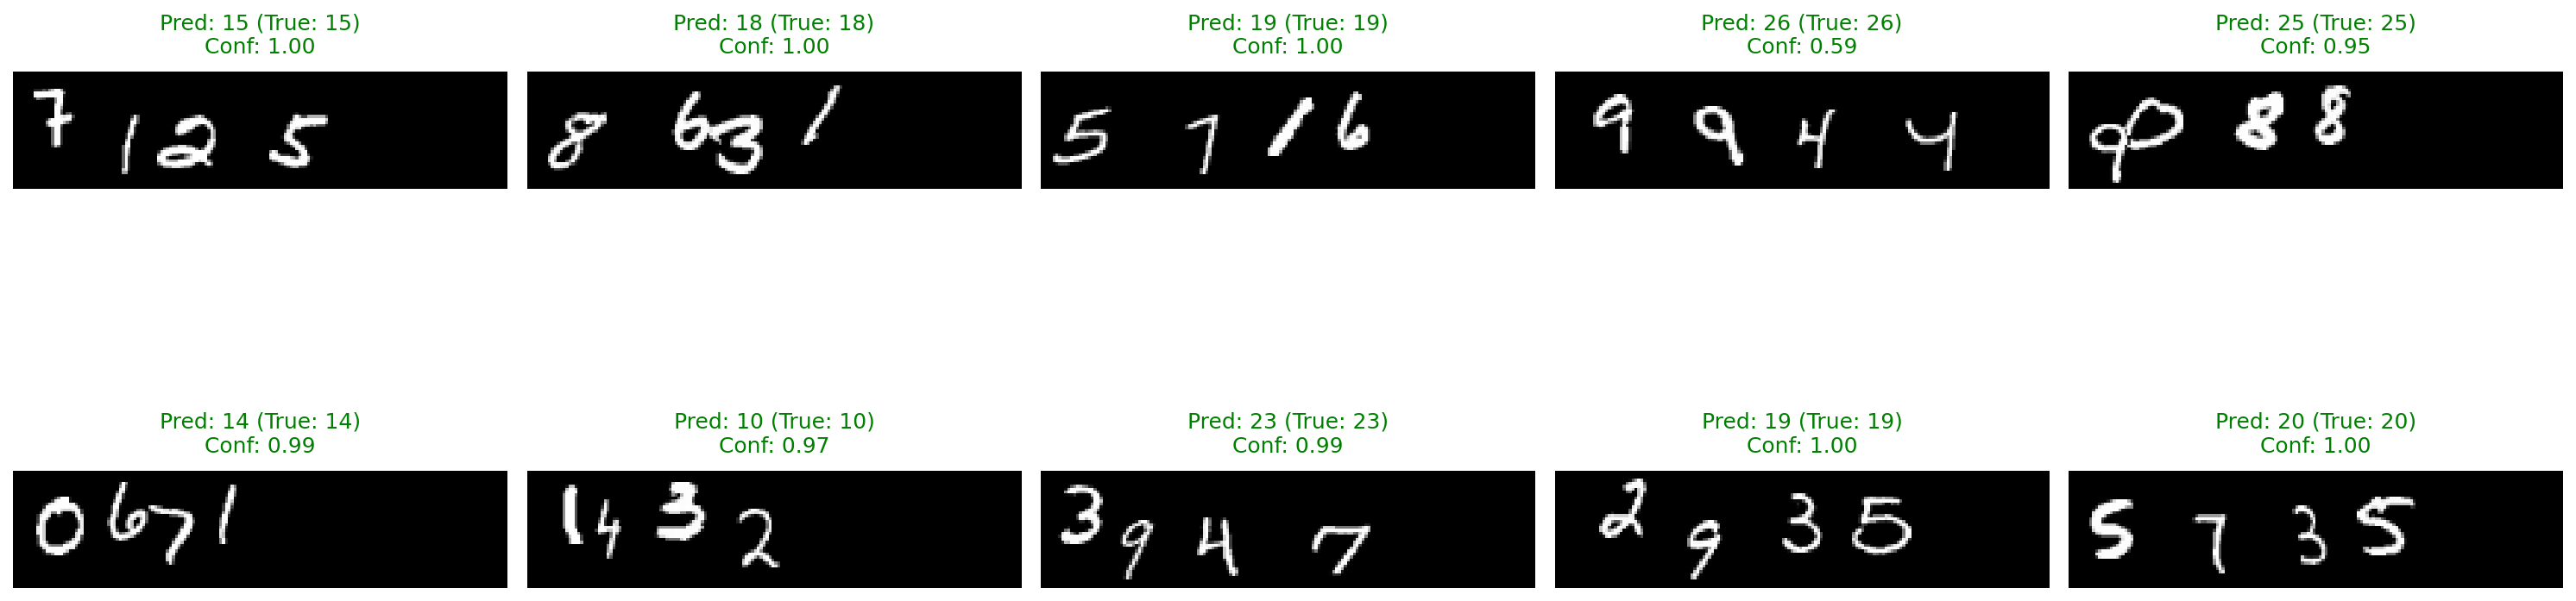

In [12]:
Image(filename='prediction_samples.png')

## Secondary

In [ ]:
# load the best model
model = LitResNetModel.load_from_checkpoint('/data/gaurav.bhole/MLNS/final_train_orig/resnet_model-epoch=86-val_loss=0.4207.ckpt')

# Test the model
print("\nEvaluating the model on the test set...")
trainer = pl.Trainer(devices=1, num_nodes=1)
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Evaluating the model on the test set...
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 59.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8370000123977661     │
│         test_loss         │    0.5871447324752808     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5871447324752808, 'test_acc': 0.8370000123977661}]

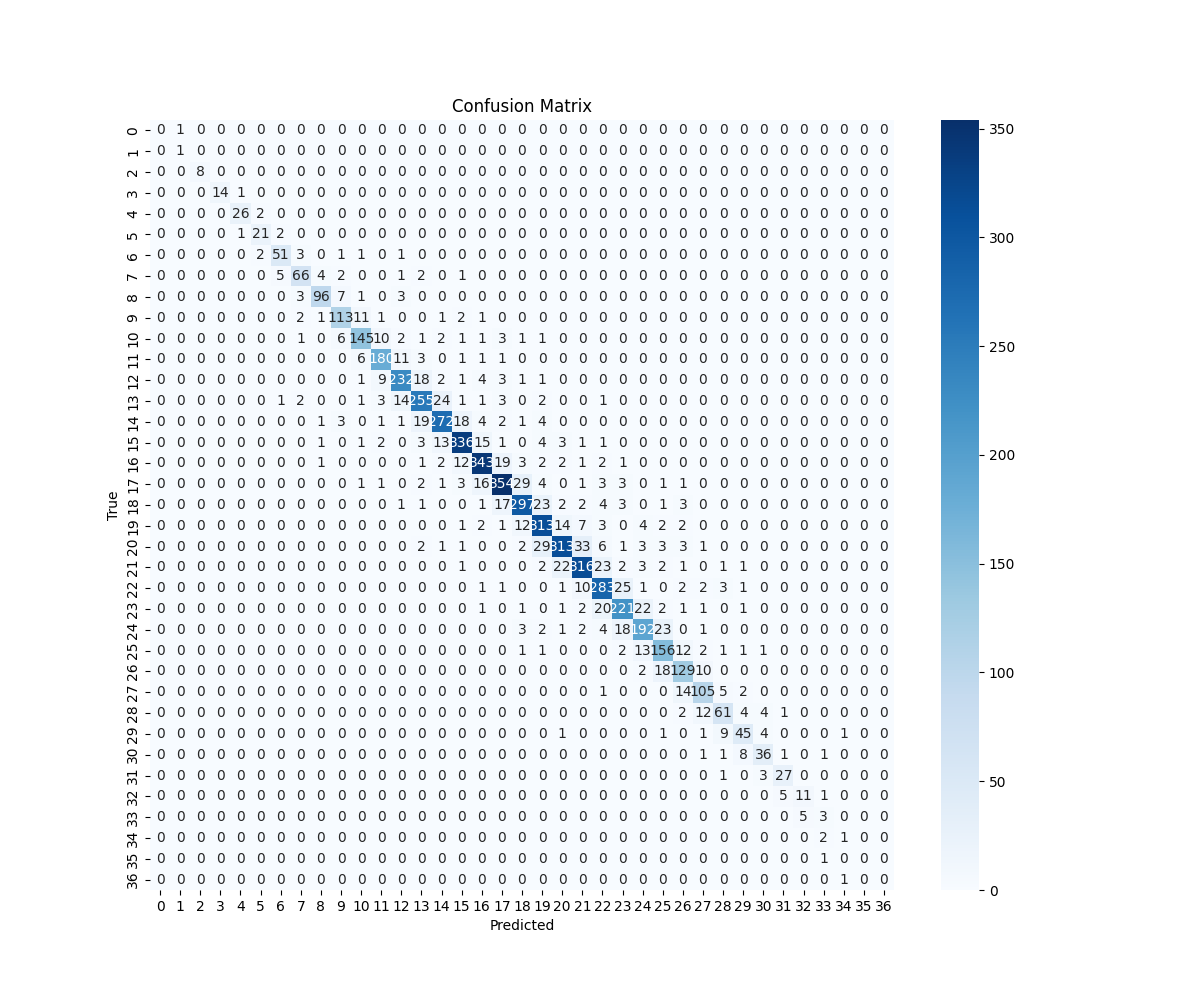

In [ ]:
Image(filename='confusion_matrix.png')